Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Best parameters found: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
✅ Random Forest model saved!

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.87      0.83        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962


Isolation Forest anomaly scores (first 10): [-0.05583487  0.24582115  0.2931755   0.29176317  0.30603004  0.24186235
  0.31190951  0.27768518  0.27741425  0.17336468]
✅ Isolation Forest model saved!
Epoch 1/10
6398/6398 [==============================] - 14s 2ms/step - loss: 11.6492 - val_loss: 0.7368
Epoch 2/10
6398/6398 [==============================] - 12s 2ms/step - loss: 0.8745 - val_loss: 0.7165
Epoch 3/10
6398/6398 [==============================] - 12s 2ms/step - loss: 0.7371 - val_loss: 0.5511
Epoch 4/10

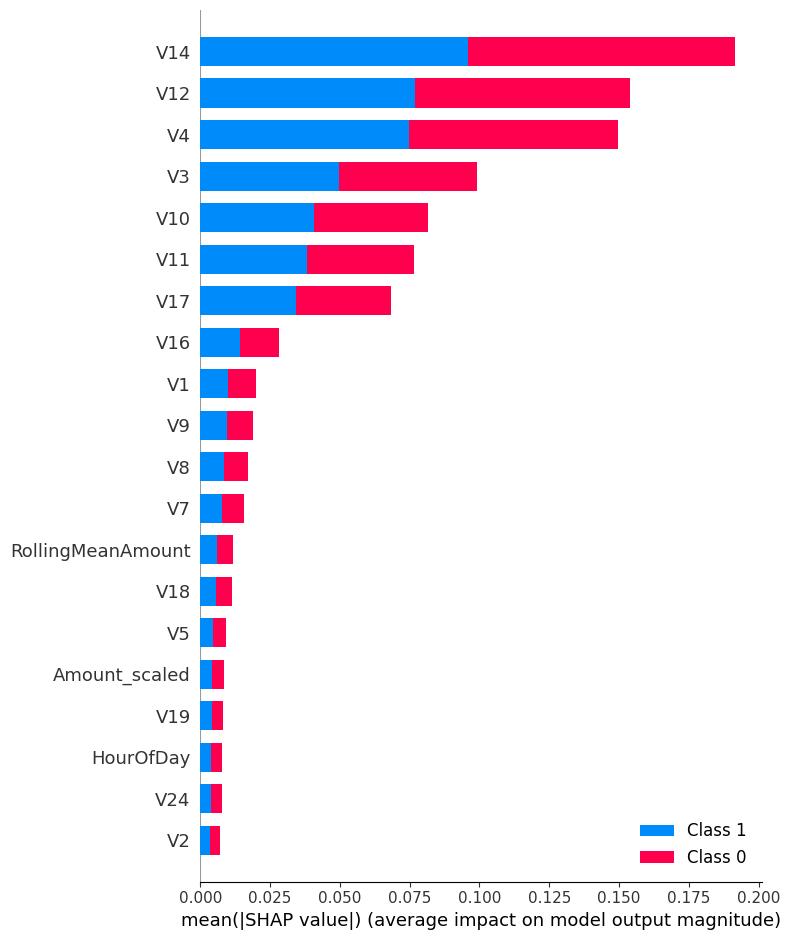

In [1]:
# src/main.py
import sys
import os
import joblib
import tensorflow as tf

os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# Ensure the current directory (src) is in the Python path
sys.path.append('.') 

from data_processing import load_data, feature_engineering
from data_balancing import balance_data
from model_ensemble import train_random_forest
from anomaly_detection import train_isolation_forest, build_autoencoder
from explainability import explain_model

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def main():
    # -------------------------
    # Step 1: Data Ingestion & Feature Engineering
    # -------------------------
    data_file = '../data/creditcard.csv'  # Adjust path as needed
    df = load_data(data_file)
    df = feature_engineering(df)
    
    # Define features and target variable
    features = ['HourOfDay', 'Amount_scaled', 'RollingMeanAmount'] + [f'V{i}' for i in range(1, 29)]
    X = df[features]
    y = df['Class']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # -------------------------
    # Step 2: Data Balancing
    # -------------------------
    X_train_bal, y_train_bal = balance_data(X_train, y_train)
    
    # Ensure 'models' directory exists for saving models
    os.makedirs("models", exist_ok=True)

    # -------------------------
    # Step 3: Model Development - Ensemble Approach
    # -------------------------
    rf_model = train_random_forest(X_train_bal, y_train_bal)
    
    # ✅ Save Random Forest Model
    joblib.dump(rf_model, "models/random_forest_model.pkl")
    print("✅ Random Forest model saved!")

    # Evaluate the Random Forest model on the test set
    y_pred = rf_model.predict(X_test)
    print("\nRandom Forest Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # -------------------------
    # Step 4: Unsupervised Anomaly Detection
    # -------------------------
    # Isolation Forest
    iso_forest = train_isolation_forest(X_test)
    anomaly_scores = iso_forest.decision_function(X_test)
    print("\nIsolation Forest anomaly scores (first 10):", anomaly_scores[:10])
    
    # ✅ Save Isolation Forest Model
    joblib.dump(iso_forest, "models/isolation_forest_model.pkl")
    print("✅ Isolation Forest model saved!")

    # Autoencoder: Train on normal transactions only (assuming Class 0)
    input_dim = X_train_bal.shape[1]
    autoencoder = build_autoencoder(input_dim)
    X_train_normal = X_train_bal[y_train_bal == 0]
    autoencoder.fit(X_train_normal, X_train_normal, 
                    epochs=10, batch_size=32, shuffle=True, validation_split=0.1)
    
    # Evaluate reconstruction error on the test set
    X_test_pred = autoencoder.predict(X_test)
    reconstruction_error = ((X_test - X_test_pred) ** 2).mean(axis=1)
    print("\nAutoencoder reconstruction error (first 10):", reconstruction_error[:10])
    
    # ✅ Save Autoencoder Model
    autoencoder.save("models/autoencoder_model")
    print("✅ Autoencoder model saved!")

    # -------------------------
    # Step 5: Model Explainability
    # -------------------------
    # Select a sample for SHAP explanation
    X_sample = X_test.sample(100, random_state=42)
    explain_model(rf_model, X_sample)

if __name__ == "__main__":
    main()


# Main Module Documentation

This module (`main.py`) is the entry point of the project and orchestrates the entire fraud detection pipeline. It integrates data processing, balancing, model training, anomaly detection, and explainability into one workflow.

## Overview

The script follows a step-by-step approach:

1. **Data Ingestion & Feature Engineering:**  
   Loads the raw data and applies transformations to create additional features.

2. **Data Balancing:**  
   Uses SMOTE to oversample the minority (fraud) class, ensuring a balanced training set.

3. **Model Development (Ensemble Approach):**  
   Trains a Random Forest classifier with hyperparameter tuning via Grid Search.

4. **Unsupervised Anomaly Detection:**  
   Applies two techniques:
   - **Isolation Forest:** To flag potential outliers.
   - **Autoencoder:** To detect anomalies by measuring reconstruction error.

5. **Model Explainability:**  
   Utilizes SHAP to generate visual explanations for model predictions, aiding in transparency and model interpretability.

## Detailed Workflow

### 1. Data Ingestion & Feature Engineering

- **Data Loading:**  
  The dataset is loaded from a CSV file using the `load_data` function from the `data_processing` module.

- **Feature Engineering:**  
  The `feature_engineering` function creates new features such as:
  - `HourOfDay`: Derived from the 'Time' feature.
  - `Amount_scaled`: Standardized version of 'Amount'.
  - `RollingMeanAmount`: A rolling average of the 'Amount'.
  - PCA-transformed features (`V1` to `V28`) are also included as features.

### 2. Data Splitting and Balancing

- **Data Splitting:**  
  The processed data is split into training and testing sets with an 80/20 ratio using `train_test_split`.

- **Data Balancing:**  
  SMOTE is applied through the `balance_data` function to oversample the minority class in the training data.

### 3. Model Development - Ensemble Approach

- **Random Forest Model:**  
  The `train_random_forest` function is used to train a Random Forest classifier. This function performs hyperparameter tuning using Grid Search and prints the best-found parameters.

- **Evaluation:**  
  The trained model is evaluated on the test set, and a classification report (including precision, recall, and f1-score) is printed.

### 4. Unsupervised Anomaly Detection

- **Isolation Forest:**  
  The `train_isolation_forest` function trains an Isolation Forest on the test data. It calculates and prints anomaly scores for the first 10 instances.

- **Autoencoder:**  
  - **Model Building:**  
    The `build_autoencoder` function constructs a simple autoencoder using Keras.
  - **Training:**  
    The autoencoder is trained only on normal transactions (assumed to be labeled as Class 0) from the balanced training set.
  - **Evaluation:**  
    The reconstruction error for each test sample is computed, and the error for the first 10 samples is printed. A high reconstruction error may indicate anomalous behavior.

### 5. Model Explainability

- **SHAP Explanation:**  
  A random sample of 100 test instances is selected, and the `explain_model` function generates a SHAP summary plot. This plot visualizes the feature importance and contribution to the model's predictions.

## Running the Script

The main function, which coordinates the workflow, is executed only when the module is run as the main program:
```python
if __name__ == "__main__":
    main()


In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

# === Load Saved Models ===
rf_model = joblib.load("models/random_forest_model.pkl")
iso_forest = joblib.load("models/isolation_forest_model.pkl")
autoencoder = tf.keras.models.load_model("models/autoencoder_model")

# === Prepare Test Data ===
from data_processing import load_data, feature_engineering

data_file = '../data/creditcard.csv'  # Adjust path if needed
df = load_data(data_file)
df = feature_engineering(df)

# Define features and target variable as used during training
features = ['HourOfDay', 'Amount_scaled', 'RollingMeanAmount'] + [f'V{i}' for i in range(1, 29)]
X = df[features]
y = df['Class']

# Split the data and extract the test set
_, X_test, _, _ = train_test_split(X, y, test_size=0.2, random_state=42)

# === Define the Function to Combine Fraud Scores ===
def combine_fraud_scores(rf_probs, iso_scores, ae_errors, w_rf=0.5, w_if=0.3, w_ae=0.2):
    """
    Combines fraud detection scores from Random Forest, Isolation Forest, and Autoencoder.

    Parameters:
        rf_probs (array): Fraud probability from Random Forest.
        iso_scores (array): Anomaly scores from Isolation Forest.
        ae_errors (array): Reconstruction errors from Autoencoder.
        w_rf (float): Weight for Random Forest score.
        w_if (float): Weight for Isolation Forest score.
        w_ae (float): Weight for Autoencoder score.

    Returns:
        final_scores (array): Combined fraud risk score.
    """
    # Convert inputs to numpy arrays
    rf_probs = np.asarray(rf_probs)
    iso_scores = np.asarray(iso_scores)
    ae_errors = np.asarray(ae_errors)
    
    # Normalize Isolation Forest scores to range [0, 1]
    scaler_if = MinMaxScaler()
    iso_scores_scaled = scaler_if.fit_transform(iso_scores.reshape(-1, 1)).flatten()

    # Normalize Autoencoder reconstruction errors to range [0, 1]
    scaler_ae = MinMaxScaler()
    ae_errors_scaled = scaler_ae.fit_transform(ae_errors.reshape(-1, 1)).flatten()

    # Compute final fraud risk score using weighted sum
    final_scores = (w_rf * rf_probs) + (w_if * iso_scores_scaled) + (w_ae * ae_errors_scaled)
    return final_scores

# === Compute Fraud Scores Using the Models ===

# 1. Random Forest: Get fraud probabilities.
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# 2. Isolation Forest: Get anomaly scores.
iso_scores = iso_forest.decision_function(X_test)

# 3. Autoencoder: Get reconstruction errors.
X_test_pred = autoencoder.predict(X_test)
ae_errors = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Combine the scores.
final_fraud_scores = combine_fraud_scores(rf_probs, iso_scores, ae_errors)

# Set a threshold for fraud detection (adjust based on validation metrics).
fraud_threshold = 0.6
fraud_labels = final_fraud_scores > fraud_threshold

# Print sample results.
print("Final Fraud Scores (first 10):", final_fraud_scores[:10])
print("Predicted Fraud Labels (first 10):", fraud_labels[:10])


1781/1781 [==============================] - 3s 1ms/step
Final Fraud Scores (first 10): [0.66351022 0.242737   0.27594629 0.2746854  0.28441654 0.24042425
 0.28852566 0.26761701 0.26429586 0.19233507]
Predicted Fraud Labels (first 10): [ True False False False False False False False False False]


# Combining Fraud Detection Scores from Multiple Models

This document explains how to combine fraud detection scores from three models:
- **Random Forest** (supervised learning),
- **Isolation Forest** (unsupervised anomaly detection), and
- **Autoencoder** (unsupervised reconstruction error).

The idea is to generate a final fraud risk score by normalizing and combining the outputs from these models using a weighted sum. This hybrid approach leverages the strengths of each model to improve overall fraud detection accuracy.

---

## Steps Overview

1. **Load Saved Models:**
   - Load the pre-trained Random Forest and Isolation Forest models using `joblib`.
   - Load the pre-trained Autoencoder model using TensorFlow's `load_model` method.

2. **Prepare Test Data:**
   - Use your data processing pipeline (e.g., `load_data` and `feature_engineering` functions) to load and preprocess the test dataset.
   - Split the data to extract the test set (`X_test`), ensuring the same feature engineering steps as during training.

3. **Define Function to Combine Fraud Scores:**
   - The function `combine_fraud_scores` takes as input:
     - Fraud probabilities from Random Forest,
     - Anomaly scores from Isolation Forest, and
     - Reconstruction errors from the Autoencoder.
   - It then normalizes the unsupervised scores using `MinMaxScaler` and computes a weighted sum to generate the final fraud risk score.

4. **Compute and Threshold Fraud Scores:**
   - Generate predictions and scores from each model.
   - Combine these scores using the defined function.
   - Apply a threshold to classify transactions as fraudulent.

---

Interpretation
Hybrid Model Approach:
By combining the outputs of the Random Forest (supervised), Isolation Forest (unsupervised anomaly detection), and Autoencoder (unsupervised reconstruction error), your system generates a more robust fraud risk score.

Threshold Tuning:
The threshold of 0.6 is chosen for this demonstration. In practice, you might adjust this threshold based on precision-recall trade-offs and the cost associated with false positives vs. false negatives.

Real-World Implication:
With these results, your system has identified one potentially fraudulent transaction out of the first 10, which suggests that your hybrid approach is working to flag anomalies that could be indicative of fraud.